In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
LOG.propagate = False

In [44]:
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-03-25 00:26:31,834 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:04:26:a3:64


2025-03-25 00:26:34,751 | INFO     |: Connected to c0:81:04:26:a3:64


In [45]:
ble.disconnect()

2025-03-23 16:19:14,371 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [21]:
ble.send_command(CMD.PING, "")

In [22]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [45]:
ble.send_command(CMD.SET_PID_GAINS, "0.08|0.0005|1.0")

In [69]:
ble.send_command(CMD.SET_PID_GAINS, "2.5|0.02|0.7")

In [70]:
ble.send_command(CMD.SET_SETPOINT, "90")

In [46]:
ble.send_command(CMD.START_PID, "")

In [47]:
ble.send_command(CMD.STOP_PID, "")

In [48]:
results = []
# ble.stop_notify(ble.uuid['RX_STRING'])
def notification_handler(uuid, byte_array):
    time, tof, pwm, kf = ble.bytearray_to_string(byte_array).split('|')
    results.append([float(time), float(tof), int(pwm), float(kf)])

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)
ble.send_command(CMD.SEND_PID_DATA, "")

In [54]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [49]:
print(results)

[[32694.0, 330.0, -2, 330.0], [32696.0, 330.0, -2, 330.0], [32712.0, 330.0, -2, 330.0], [32723.0, 330.0, -2, 330.0], [32734.0, 330.0, -2, 330.0], [32749.0, 330.0, -2, 330.0], [32758.0, 330.0, -2, 330.0], [32771.0, 330.0, -2, 330.0], [32781.0, 330.0, -2, 330.0], [32786.0, 330.0, -2, 330.0], [32793.0, 330.0, -2, 330.0], [32804.0, 311.0, 0, 315.173], [32813.0, 311.0, 0, 315.173], [32815.0, 311.0, 0, 315.173], [32819.0, 311.0, 0, 315.173], [32821.0, 311.0, 0, 315.173], [32830.0, 306.0, 0, 308.062], [32833.0, 306.0, 0, 308.062], [32840.0, 306.0, 0, 308.062], [32843.0, 306.0, 0, 308.062], [32846.0, 306.0, 0, 308.062], [32855.0, 333.0, -1, 327.254], [32858.0, 333.0, -1, 327.254], [32869.0, 333.0, -1, 327.254], [32874.0, 333.0, -1, 327.254], [32885.0, 333.0, -1, 327.254], [32896.0, 333.0, -1, 327.254], [32901.0, 333.0, -1, 327.254], [32911.0, 333.0, -1, 327.254], [32922.0, 333.0, -1, 327.254], [32937.0, 333.0, -1, 327.254], [32948.0, 333.0, -1, 327.254], [32965.0, 333.0, -1, 327.254], [32976.0

In [ ]:
import csv
import datetime

# Generate filename with timestamp to avoid overwriting
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"robot_data_{timestamp}.csv"

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Time (ms)', 'Distance (mm)', 'PWM'])
    # Write all data rows
    csvwriter.writerows(results)

print(f"Data saved to {filename}")

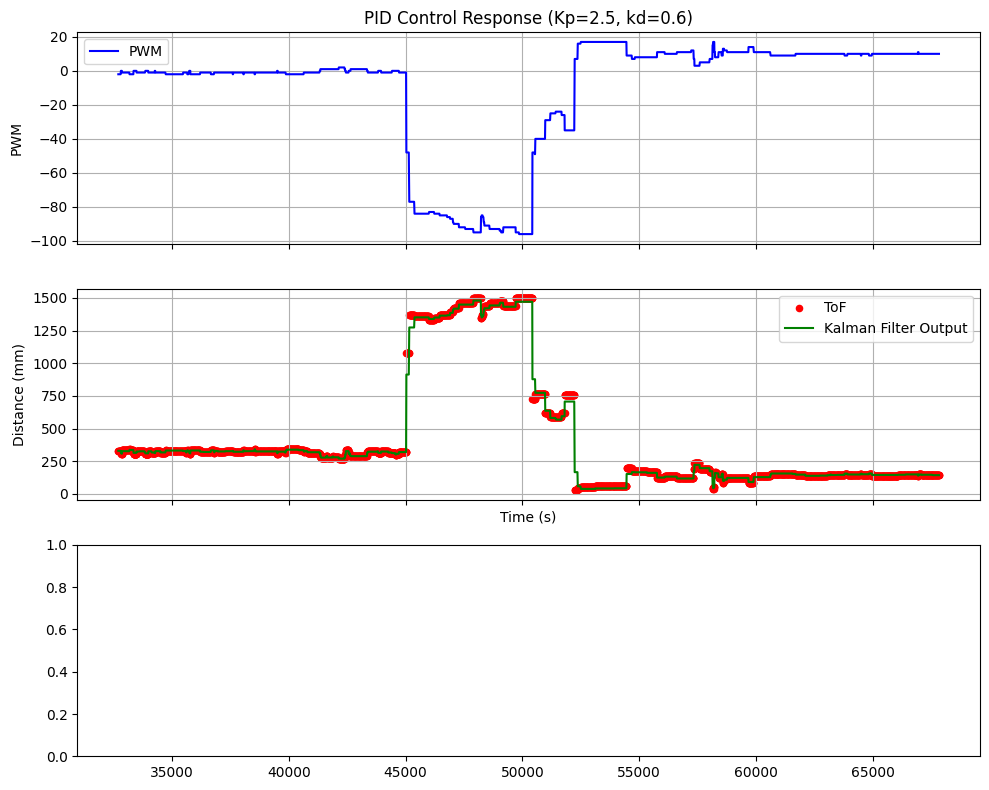

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert results to numpy array for easier handling
data = np.array(results)
time = data[:, 0]
tof = data[:, 1]
pwm = data[:, 2]
kf = data[:, 3]

# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot PWM vs Time
ax1.plot(time, pwm, 'b-', label='PWM')
ax1.set_ylabel('PWM')
ax1.set_title('PID Control Response (Kp=2.5, kd=0.6)')
ax1.grid(True)
ax1.legend()

# Plot ToF vs Time
ax2.scatter(time, tof, color='r', s=20, label='ToF')
ax2.plot(time, kf, 'g-', label='Kalman Filter Output')

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Distance (mm)')
# Set y-axis ticks in steps of 100
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()